In [5]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import seaborn as sns

In [6]:
# Set the model and labels
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'
parameterization = 'bs_C'
use_theory_cov = True
labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']

param_bounds = None #np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
params_prior = None

# # # Load in the data
loader = DataLoader(E_min, E_max, which_data)
data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

# # # Set the parameter bounds and initialize the model
if parameterization == 'standard':
    sys.stderr.write('No Longer Supported....')
    sys.exit(-1)
elif parameterization == 'bound_state':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [-1, 1], [-6, 6], [-1, 1], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [0.0, 0.1], [0.0, 1.6], [0.0, 0.1], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    sys.stderr.write('Not implemented yet...')
    sys.exit(-1)
elif parameterization == 'bs_C':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
elif parameterization == 'initial_f_wave':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6], [-3, 0]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6], [-0.5, 1]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.F_Wave_AR(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)

In [7]:
# Load in each of the sample files
file_pairs = [['./11_25_2023/run0/samples_0.h5', './11_25_2023/run1/samples_1.h5'],
              ['./11_25_2023/run2/samples_2.h5', './11_25_2023/run3/samples_3.h5']]

titles = ['SM P1+', 'SM P1-']
overlap_bounds = [[1.8, 1.7], [1.66, 1.6]]
parameter_overlap = [3, 5]

[20]
[311]
9.200596292260065e+118
[]
[311, 1879]
1.0582672304803336e+119


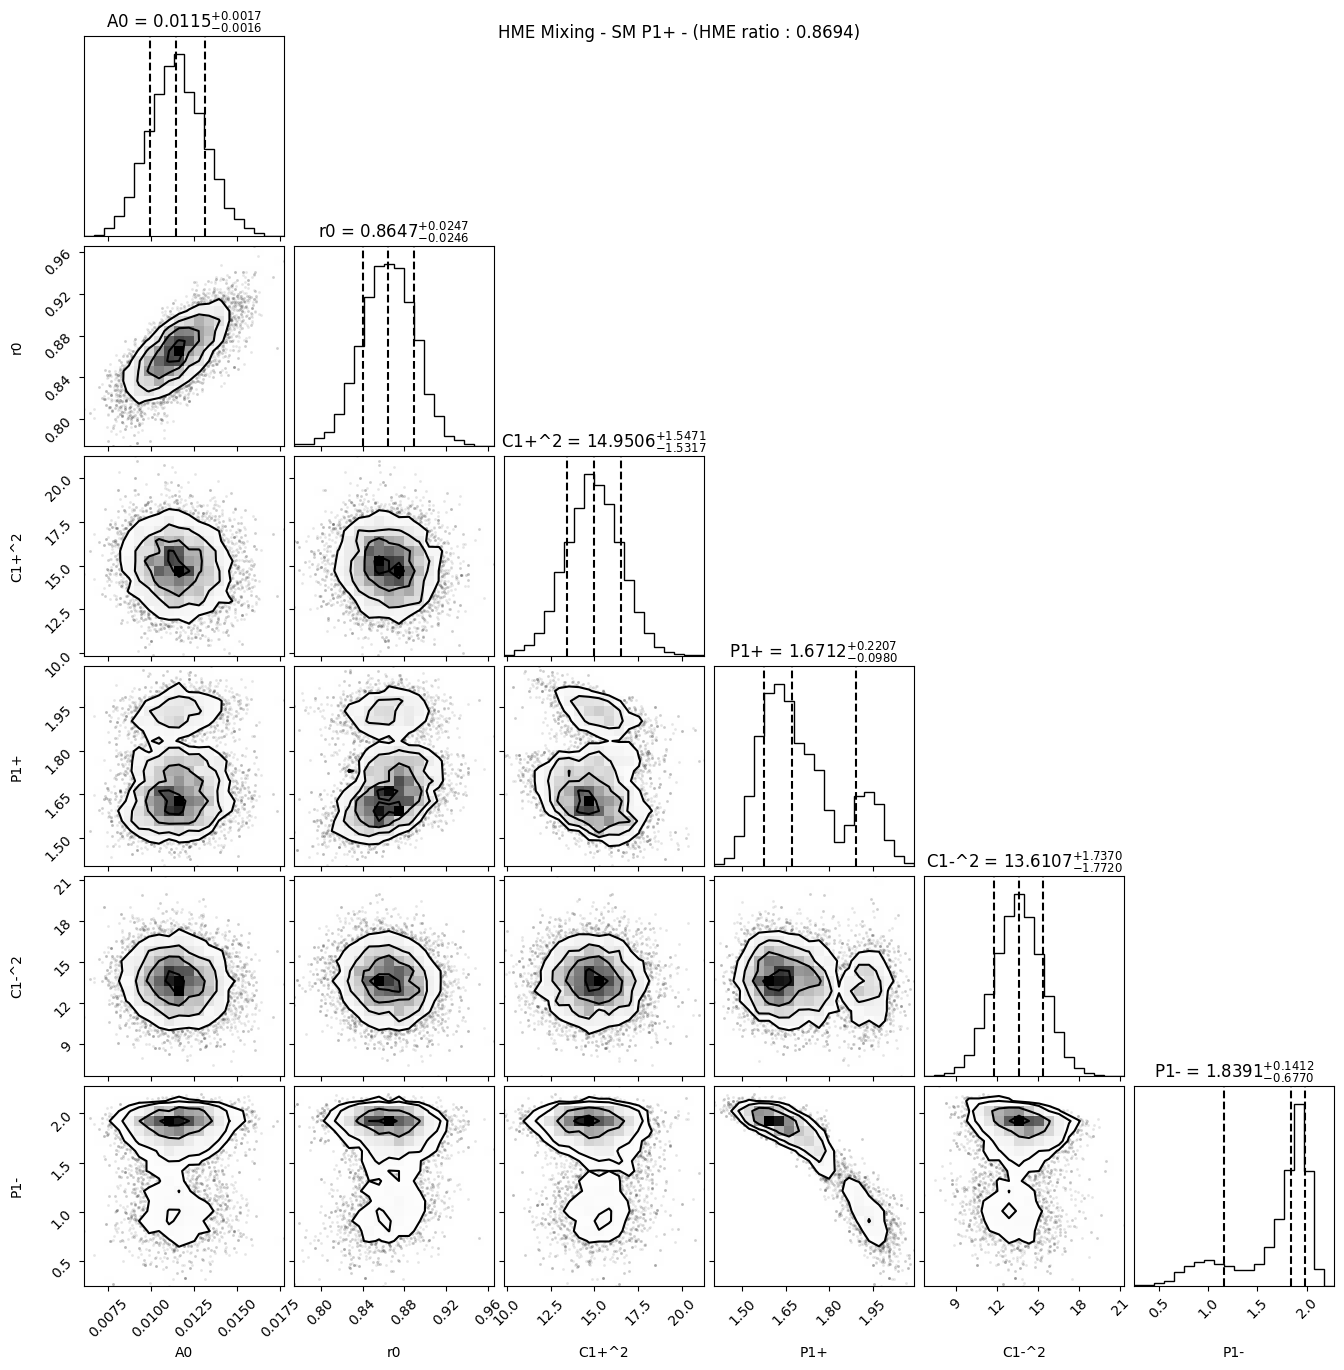

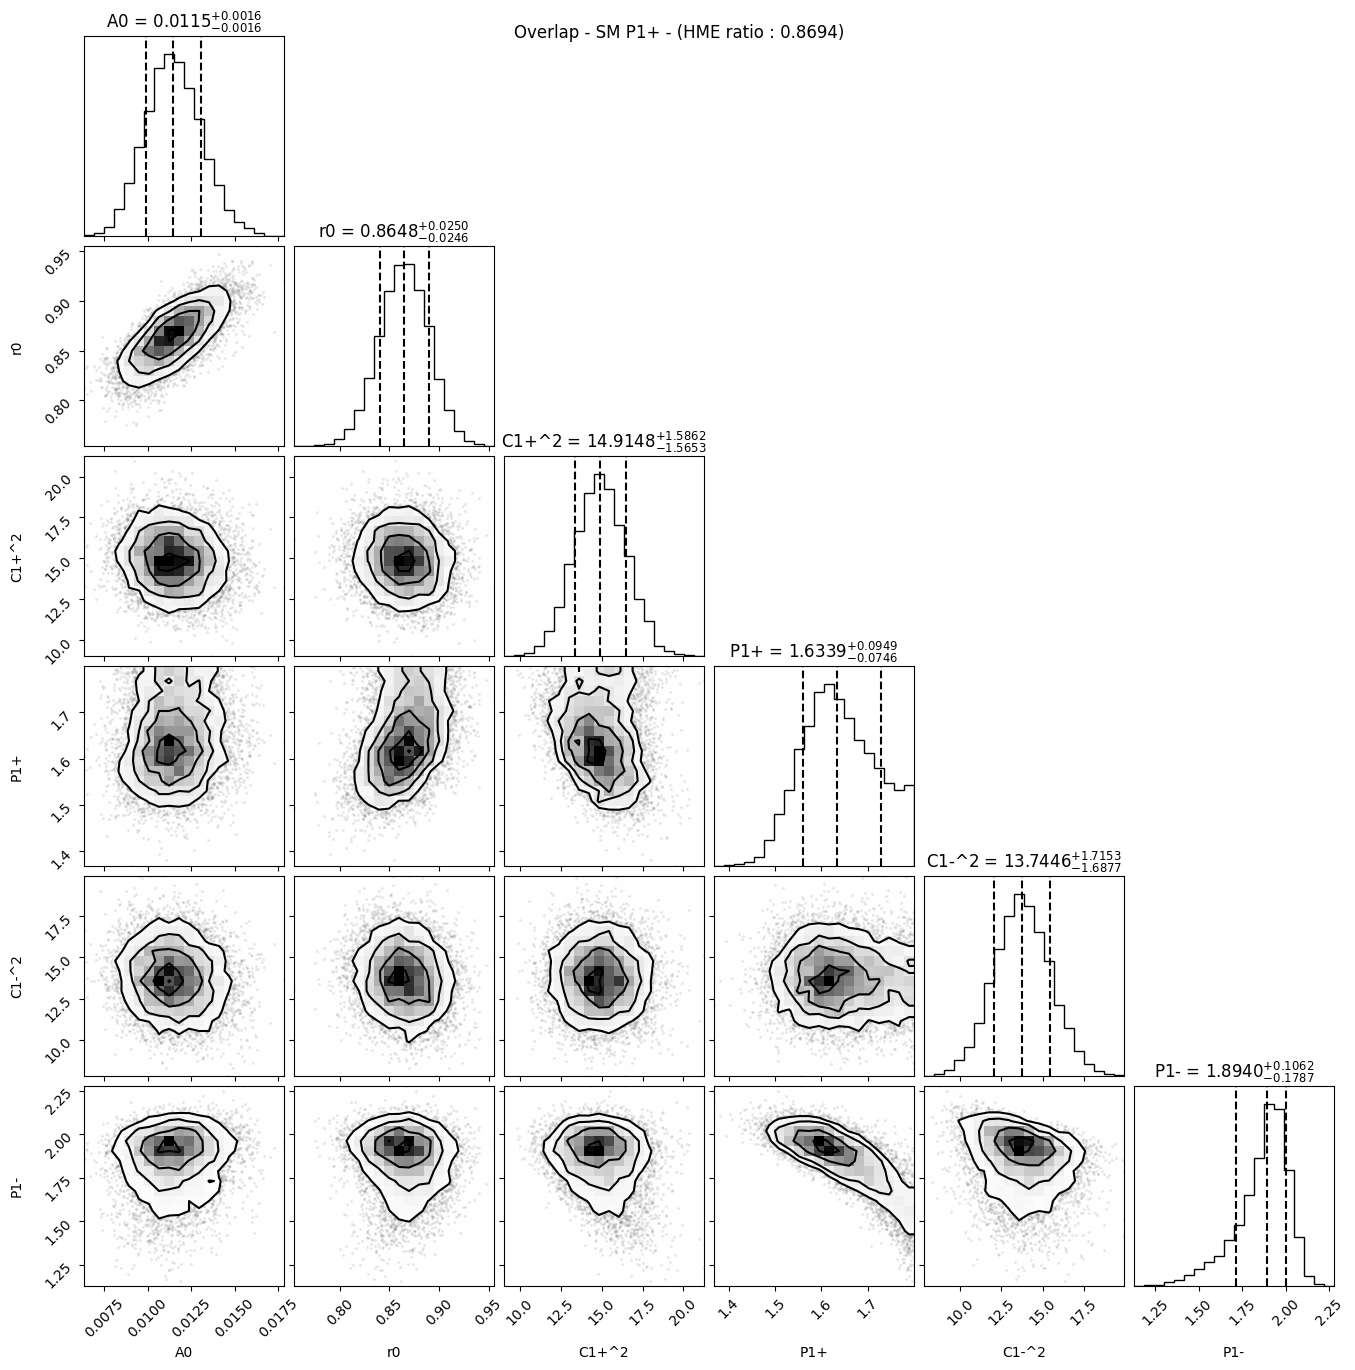

[11]
[341]
1.5072811111304947e+118
[ 3 19]
[341, 128]
5.936429507878165e+116


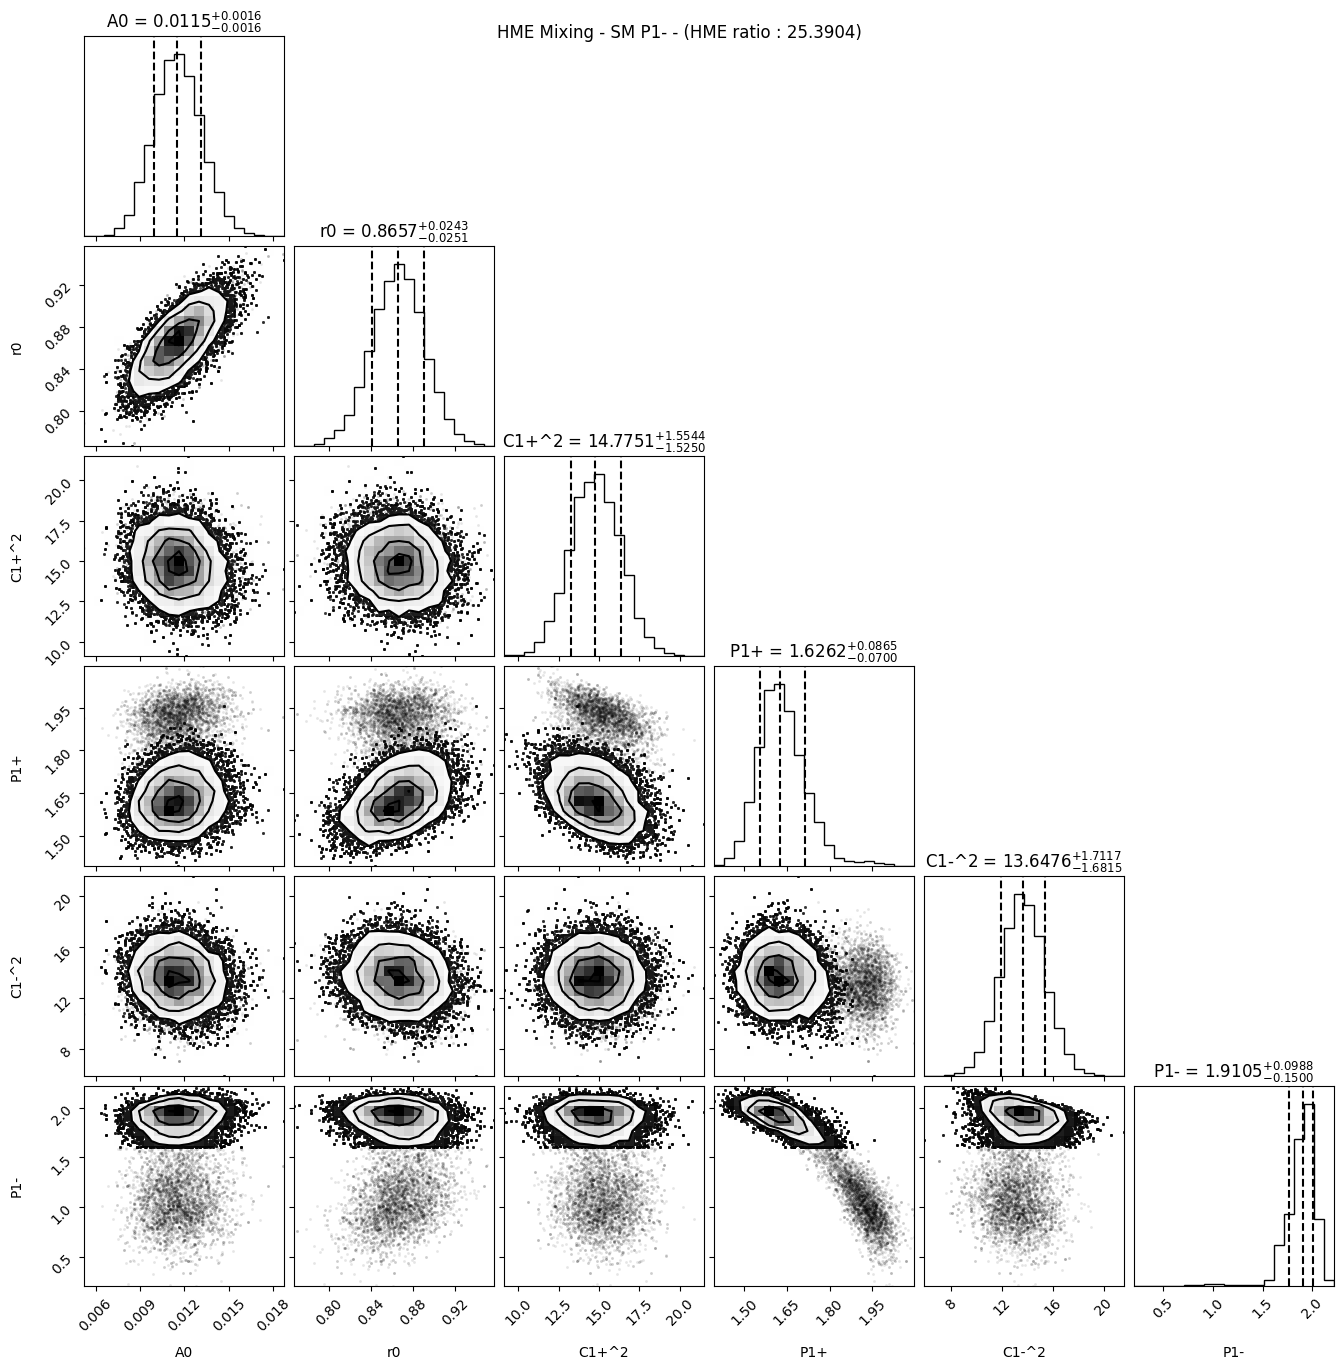

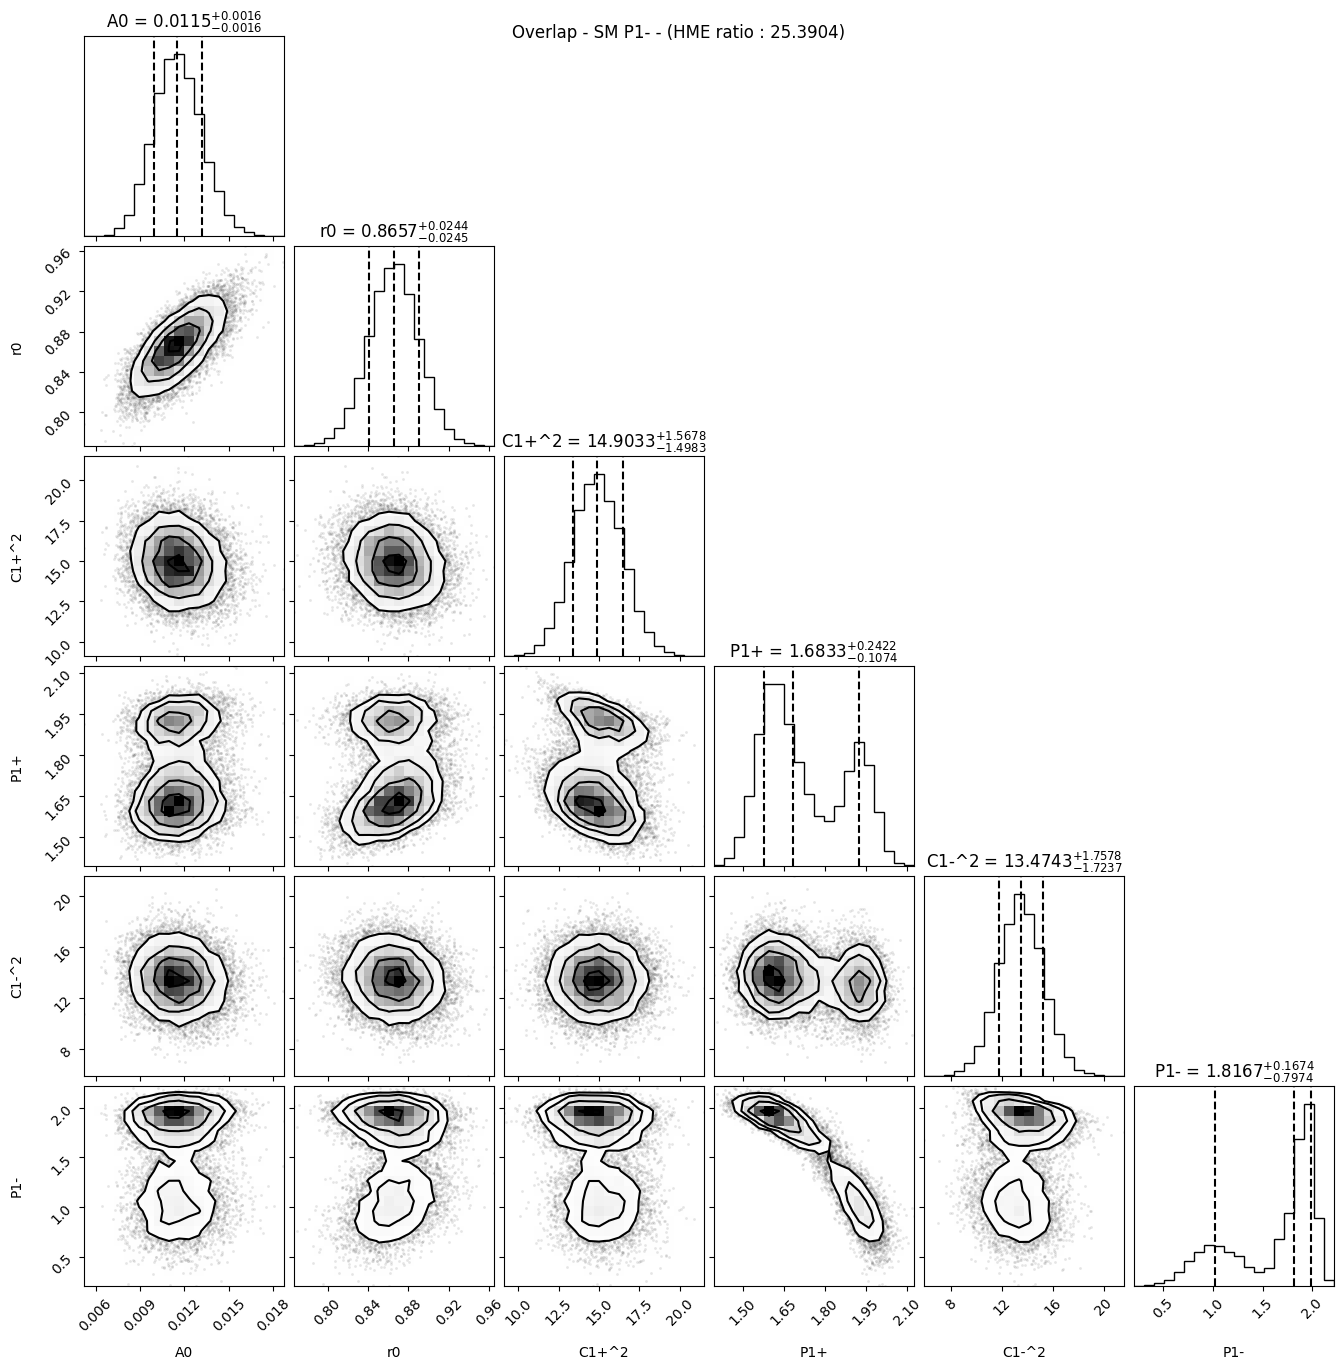

In [8]:
c = 0
for pair in file_pairs:
    n_burn = 50000

    all_samples = []
    hmes = []
    ms = []
    n_in_overlap_region = []

    for i in range(0, 2):
        # Set up the reader
        reader = emcee.backends.HDFBackend(pair[i])

        # Load in the samples
        samples_not_flat = reader.get_chain()

        # Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
        within_chain_means = np.mean(samples_not_flat[n_burn:, :, :], axis = 0)

        # Create an empty array of the within chain variances
        within_chain_var = np.empty(within_chain_means.shape)

        # Run a for loop across all walkers to compute the within chain variance
        for j in range(0, within_chain_means.shape[0]):
            within_chain_var[j, :] = np.sum(np.square(within_chain_means[j, :] - samples_not_flat[n_burn:, j, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

        # Get the typical within chain variance W for each parameter
        W = np.median(within_chain_var, axis = 0)

        # Now we need to loop over each chain for each parameter to see how it compares to the typical variance
        bad_indices = []
        ratios = np.empty(within_chain_means.shape)

        # Loop over each parameter
        for k in range(0, within_chain_means.shape[1]):
            # Loop over the walkers
            for j in range(0, within_chain_means.shape[0]):
                ratio = np.sum(within_chain_var[j, k] / W[k]) / within_chain_means.shape[1]
                ratios[j, k] = ratio

        # Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
        total_normalized_ratios = np.sum(ratios, axis = 1)
        bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
        # print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
        print(bad_indices)

        if bad_indices.shape[0] != 0:
            # Remove the bad walkers
            samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

        # Thin the samples
        thinned_samples_not_flat = samples_not_flat[n_burn:, :, :]

        # Compute the autocorrelation times for each parameter
        ac_s = reader.get_autocorr_time(discard = n_burn, tol = 0)
        ac = int(np.max(ac_s))

        # Thin according to the autocorrelation time
        thinned_samples_not_flat = thinned_samples_not_flat[::ac, :, :]

        # Flatten the samples
        len0, len1, len2 = thinned_samples_not_flat.shape
        samples_flat = np.reshape(thinned_samples_not_flat, (len0 * len1, len2))
        all_samples.append(samples_flat)

        # See how many are in the overlap region
        if i == 0:
            overlap = np.where(samples_flat[:, parameter_overlap[c]] <= overlap_bounds[c][i])[0].shape[0]
        else:
            overlap = np.where(samples_flat[:, parameter_overlap[c]] >= overlap_bounds[c][i])[0].shape[0]
        n_in_overlap_region.append(overlap)

        print(n_in_overlap_region)

        # Get the likelihoods and the number of samples
        LL = [model.log_likelihood(i).real for i in samples_flat]
        likelihoods = np.exp(LL)
        m = likelihoods.shape[0]
        ms.append(m)

        # Compute and append the harmonic mean estimator
        hme = 1 / (np.sum(1 / likelihoods) / m)
        hmes.append(hme)
        print(hme)

    # Use the HME to normalize the peaks
    hme_ratio = hmes[0] / hmes[1]
    n0 = int(hme_ratio * ms[0])
    n1 = int(ms[1])

    indices0 = np.random.choice(np.arange(0, all_samples[0].shape[0]), n0)
    indices1 = np.random.choice(np.arange(0, all_samples[1].shape[0]), n1)

    samples = np.concatenate([all_samples[0][indices0], all_samples[1][indices1]])

    corner.corner(samples[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
    plt.suptitle('HME Mixing - {} - (HME ratio : {:.4f})'.format(titles[c], hme_ratio))
    plt.show()

    # # Use the overlap to normalize the peaks
    # frac_keep = int((all_samples[1].shape[0] * n_in_overlap_region[0]) / (all_samples[0].shape[0] * n_in_overlap_region[1]))
    # n_keep = int(all_samples[0].shape[0] * frac_keep)
    # keep_indices = np.floor(np.linspace(0, all_samples[0].shape[0] - 1, n_keep)).astype(int)
    # overlap_samples = np.concatenate([all_samples[0][keep_indices], all_samples[1]])

    # corner.corner(overlap_samples[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
    # plt.suptitle('Overlap - {} - (HME ratio : {:.4f})'.format(titles[c], hme_ratio))
    # plt.show()

    c += 1
        
        

